In [1]:
import preprocessor, league_table, soccer_model

/Users/CEO/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [157]:
import math
import numpy as np
import pandas as pd
from itertools import cycle
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

from scipy import interp
import scipy.stats as scs
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.cluster import KMeans


import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
%run preprocessor.py

Enter path to file that you wish to preprocess: (should be a .csv file) ../data/FootballEurope/FootballEurope.csv


/Users/CEO/anaconda3/lib/python3.6/site-packages/IPython/utils/py3compat.py:188: DtypeWarning: Columns (39,61) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(compiler(f.read(), fname, 'exec'), glob, loc)


In [22]:
clean_df = preprocessor.create_model_df('../data/FootballEurope/FootballEurope.csv')

/Users/CEO/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (39,61) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [23]:
clean_df.head(1)

,awayDispossessedFT,awayPassSuccessFT,awayRatingsFT,awayDribbleSuccessFT,homeFoulsCommitedFT,homeAerialsTotalFT,awayShotsOnTargetFT,awayShotsBlockedFT,homePassesKeyFT,awayDribblesWonFT,homeCornersTotalFT,homeShotsBlockedFT,homeDribbleSuccessFT,awayAerialsTotalFT,awayPassesKeyFT,homeFormation,refereeName,homePossessionFT,awayInterceptionsFT,homeDribbledPastFT,homeDribblesWonFT,awayTackleSuccessFT,awayTeam,homeDispossessedFT,awayOffsidesCaughtFT,awayDribbledPastFT,awayFormation,homeShotsTotalFT,homePassSuccessFT,awayCornersTotalFT,homeTeam,awayFoulsCommitedFT,homeShotsOnTargetFT,homeTacklesTotalFT,homeOffsidesCaughtFT,venueName,awayDribblesAttemptedFT,homeInterceptionsFT,awayTacklesTotalFT,homeRatingsFT,homeDribblesAttemptedFT,homeTackleSuccessFT,awayPossessionFT,awayShotsTotalFT,resultsLabel
0,14.0,73.69,6.38,47.22,12,22,2.0,4.0,14,10.0,7.0,4.0,38.89,22,9.0,2,17,47.65,34,10.0,5.0,75.0,13,6,5.0,5.0,0,21,66.73,4.0,1,11,10.0,34,2.0,7,20,21,18,6.73,12.0,75.0,52.35,11.0,1


In [24]:
qwert = pd.read_csv('../data/FootballEurope/FootballEurope.csv')

/Users/CEO/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (39,61) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [26]:
qwert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9127 entries, 0 to 9126
Data columns (total 94 columns):
Unnamed: 0                 9127 non-null int64
id                         9127 non-null int64
homeTacklesTotalHT         9127 non-null int64
homeShotsTotalHT           9127 non-null int64
awayDispossessedFT         9126 non-null float64
awayPassSuccessFT          9127 non-null float64
awayRatingsFT              9127 non-null float64
awayDribbleSuccessFT       9125 non-null float64
awayDribblesAttemptedHT    9127 non-null int64
awayTeamLineUp             9127 non-null object
awayShotsBlockedHT         8906 non-null float64
awayShotsTotalHT           9126 non-null float64
homeDribbleSuccessHT       9124 non-null float64
homeFoulsCommitedFT        9127 non-null int64
homeAerialsTotalFT         9127 non-null int64
homeRatingsHT              9127 non-null float64
awayShotsOnTargetFT        9069 non-null float64
awayShotsBlockedFT         8906 non-null float64
homeInterceptionsHT       

In [27]:
qwertcols = qwert.columns
sorted(qwertcols[[39,61]])

['awayFormation', 'homeFormation']

In [28]:
qwert[sorted(qwertcols[[39,61]])].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9127 entries, 0 to 9126
Data columns (total 2 columns):
awayFormation    9127 non-null object
homeFormation    9126 non-null object
dtypes: object(2)
memory usage: 142.7+ KB


In [29]:
EPLqwert = qwert[qwert.division == 'EPL']

In [30]:
'''
key - group(count) - group description - members of group
    AA(6) - highly attacking - '343', '433','352', '3412', '3142', '4240' 
    AB(5) - attacking - '3421', '4141','3511', '4132', '4312'
    B(4) - balanced - '4231', '442', 41212', '4222',
    BD(3) - defensive -  '451', '4411', '4321'
    DD(3) - highly defensive - '541', '532', '343d'
    
    ({0: 'AA', 1: 'AB', 2: 'B', 3: 'BD', 4: 'DD'},
     {0: 'AA', 1: 'AB', 2: 'B', 3: 'BD', 4: 'DD'})
    '''
EPLqwert[['awayFormation','homeFormation']].tail(8)

,awayFormation,homeFormation
1892,532,4231
1893,4231,4231
1894,3421,442
1895,4231,4231
1896,4411,4141
1897,4231,4141
1898,4231,433
1899,4411,433


In [31]:
clean_df[['awayFormation','homeFormation']].tail(8)

,awayFormation,homeFormation
1892,4,2
1893,2,2
1894,1,2
1895,2,2
1896,3,1
1897,2,1
1898,2,0
1899,3,0


In [32]:
EPLqwert[['awayFormation','homeFormation']].head(8)

,awayFormation,homeFormation
0,343,4231
1,4231,4231
2,4231,4231
3,4231,4231
4,451,4231
5,4411,4411
6,4231,433
7,4231,4231


In [33]:
clean_df[['awayFormation','homeFormation']].head(8)

,awayFormation,homeFormation
0,0,2
1,2,2
2,2,2
3,2,2
4,3,2
5,3,3
6,2,0
7,2,2


In [34]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1900 entries, 0 to 1899
Data columns (total 45 columns):
awayDispossessedFT         1900 non-null float64
awayPassSuccessFT          1900 non-null float64
awayRatingsFT              1900 non-null float64
awayDribbleSuccessFT       1900 non-null float64
homeFoulsCommitedFT        1900 non-null int64
homeAerialsTotalFT         1900 non-null int64
awayShotsOnTargetFT        1900 non-null float64
awayShotsBlockedFT         1900 non-null float64
homePassesKeyFT            1900 non-null int64
awayDribblesWonFT          1900 non-null float64
homeCornersTotalFT         1900 non-null float64
homeShotsBlockedFT         1900 non-null float64
homeDribbleSuccessFT       1900 non-null float64
awayAerialsTotalFT         1900 non-null int64
awayPassesKeyFT            1900 non-null float64
homeFormation              1900 non-null int8
refereeName                1900 non-null int64
homePossessionFT           1900 non-null float64
awayInterceptionsFT     

In [35]:
clean_df[sorted(clean_df.filter(regex='away', axis=1).columns)].head()

,awayAerialsTotalFT,awayCornersTotalFT,awayDispossessedFT,awayDribbleSuccessFT,awayDribbledPastFT,awayDribblesAttemptedFT,awayDribblesWonFT,awayFormation,awayFoulsCommitedFT,awayInterceptionsFT,awayOffsidesCaughtFT,awayPassSuccessFT,awayPassesKeyFT,awayPossessionFT,awayRatingsFT,awayShotsBlockedFT,awayShotsOnTargetFT,awayShotsTotalFT,awayTackleSuccessFT,awayTacklesTotalFT,awayTeam
0,22,4.0,14.0,47.22,5.0,20,10.0,0,11,34,5.0,73.69,9.0,52.35,6.38,4.0,2.0,11.0,75.00,18,13
1,15,6.0,11.0,27.27,4.0,11,3.0,2,10,11,2.0,75.78,6.0,46.29,6.39,4.0,5.0,11.0,86.96,26,7
2,19,5.0,16.0,66.67,5.0,9,6.0,2,8,15,2.0,74.86,11.0,60.18,6.73,5.0,6.0,15.0,73.53,20,9
3,36,3.0,6.0,27.78,8.0,18,5.0,2,10,24,4.0,78.43,8.0,54.02,6.41,3.0,2.0,11.0,63.54,23,2
4,48,4.0,9.0,40.00,16.0,16,6.0,3,14,19,3.0,61.07,5.0,46.80,6.51,2.0,4.0,8.0,61.61,37,11


In [36]:
sorted(clean_df.columns)

['awayAerialsTotalFT',
 'awayCornersTotalFT',
 'awayDispossessedFT',
 'awayDribbleSuccessFT',
 'awayDribbledPastFT',
 'awayDribblesAttemptedFT',
 'awayDribblesWonFT',
 'awayFormation',
 'awayFoulsCommitedFT',
 'awayInterceptionsFT',
 'awayOffsidesCaughtFT',
 'awayPassSuccessFT',
 'awayPassesKeyFT',
 'awayPossessionFT',
 'awayRatingsFT',
 'awayShotsBlockedFT',
 'awayShotsOnTargetFT',
 'awayShotsTotalFT',
 'awayTackleSuccessFT',
 'awayTacklesTotalFT',
 'awayTeam',
 'homeAerialsTotalFT',
 'homeCornersTotalFT',
 'homeDispossessedFT',
 'homeDribbleSuccessFT',
 'homeDribbledPastFT',
 'homeDribblesAttemptedFT',
 'homeDribblesWonFT',
 'homeFormation',
 'homeFoulsCommitedFT',
 'homeInterceptionsFT',
 'homeOffsidesCaughtFT',
 'homePassSuccessFT',
 'homePassesKeyFT',
 'homePossessionFT',
 'homeRatingsFT',
 'homeShotsBlockedFT',
 'homeShotsOnTargetFT',
 'homeShotsTotalFT',
 'homeTackleSuccessFT',
 'homeTacklesTotalFT',
 'homeTeam',
 'refereeName',
 'resultsLabel',
 'venueName']

Enter path to file that you wish to preprocess and plot: (should be a .csv file) ../data/FootballEurope/FootballEurope.csv


/Users/CEO/DSI/dsi-CapstoneProj/src/league_table.py:67: DtypeWarning: Columns (39,61) have mixed types. Specify dtype option on import or set low_memory=False.


                EPLresultH  EPLresultA  EPLresult
Man City               220         167        387
Chelsea                213         172        385
Arsenal                208         165        373
Tottenham              197         165        362
Man Utd                197         161        358
Liverpool              190         153        343
Everton                178         112        290
Southampton            152         114        266
Stoke                  152          89        241
West Ham               147          93        240
Swansea                138          94        232
West Brom              129          88        217
Sunderland              99          79        178
Crystal Palace          89          87        176
Leicester              102          64        166
Newcastle              109          57        166
Aston Villa             73          61        134
Norwich                 78          33        111
Hull                    73          33        106


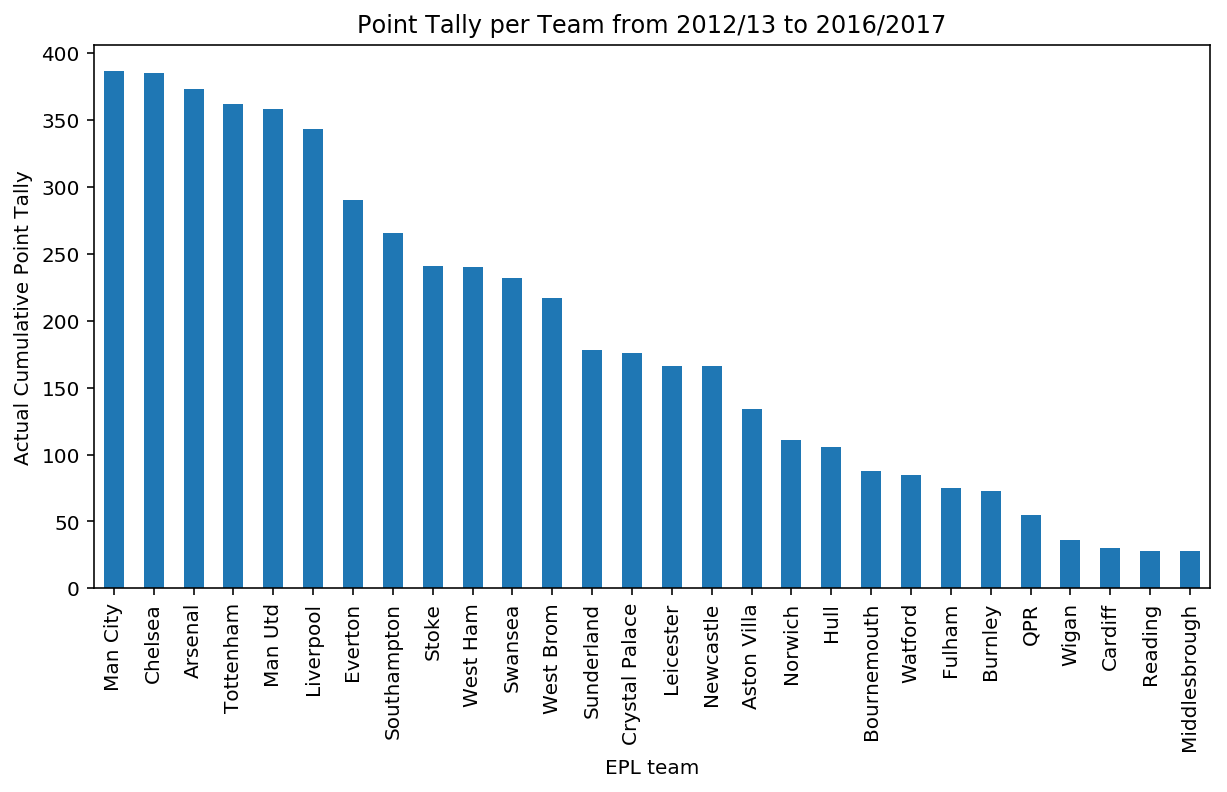

In [37]:
%run league_table.py #../data/FootballEurope/FootballEurope.csv

# Modeling

In [38]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support as PreRecF1Support_score
from sklearn.metrics import classification_report


from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV


from xgboost import XGBRegressor

In [ ]:
modeling_df = clean_df.copy()
y = modeling_df.pop('resultsLabel')
X = modeling_df.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [ ]:
rfc = RandomForestClassifier(random_state=123)
param_grid = {'n_estimators': [50, 100, 150, 200, 300],
              'max_features': [0.2, 0.4, 0.6, 0.8, 'sqrt', 'log2'],
              'max_leaf_nodes': [None, 5, 7, 10],
              'min_samples_split': [2, 4, 6, 8],
              'min_samples_leaf': [2, 4, 8],
              'max_depth': [None, 3, 6, 10],
              'bootstrap': [True, False]}

rf_GS = GridSearchCV(RandomForestClassifier(),
                             param_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='accuracy')
rf_GS.fit(X_train, y_train)
print("best RFClassifier parameters: ", rf_gridsearch.best_params_)
print("best RFClassifierModel Accuracy: ", rf_GS.score(X_test, y_test))
print("best RFClassifierModel: "rf_GS.best_estimator_
rf_opt = rf_GS.best_estimator_

In [158]:
'''RandomForestClassifier(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.4, max_leaf_nodes=None, min_samples_leaf=4,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=-1, oob_score=False, random_state=123,
           verbose=True, warm_start=False)'''

"RandomForestClassifier(bootstrap=True, criterion='mse', max_depth=None,\n           max_features=0.4, max_leaf_nodes=None, min_samples_leaf=4,\n           min_samples_split=4, min_weight_fraction_leaf=0.0,\n           n_estimators=150, n_jobs=-1, oob_score=False, random_state=123,\n           verbose=True, warm_start=False)"

# Clustering

In [92]:
clean_df.columns

Index(['awayDispossessedFT', 'awayPassSuccessFT', 'awayRatingsFT',
       'awayDribbleSuccessFT', 'homeFoulsCommitedFT', 'homeAerialsTotalFT',
       'awayShotsOnTargetFT', 'awayShotsBlockedFT', 'homePassesKeyFT',
       'awayDribblesWonFT', 'homeCornersTotalFT', 'homeShotsBlockedFT',
       'homeDribbleSuccessFT', 'awayAerialsTotalFT', 'awayPassesKeyFT',
       'homeFormation', 'refereeName', 'homePossessionFT',
       'awayInterceptionsFT', 'homeDribbledPastFT', 'homeDribblesWonFT',
       'awayTackleSuccessFT', 'awayTeam', 'homeDispossessedFT',
       'awayOffsidesCaughtFT', 'awayDribbledPastFT', 'awayFormation',
       'homeShotsTotalFT', 'homePassSuccessFT', 'awayCornersTotalFT',
       'homeTeam', 'awayFoulsCommitedFT', 'homeShotsOnTargetFT',
       'homeTacklesTotalFT', 'homeOffsidesCaughtFT', 'venueName',
       'awayDribblesAttemptedFT', 'homeInterceptionsFT', 'awayTacklesTotalFT',
       'homeRatingsFT', 'homeDribblesAttemptedFT', 'homeTackleSuccessFT',
       'awayPossession

In [93]:
data = clean_df.drop(['resultsLabel'], axis=1)

In [94]:
data = data[sorted(data.columns)]

In [95]:
data.head()

,awayAerialsTotalFT,awayCornersTotalFT,awayDispossessedFT,awayDribbleSuccessFT,awayDribbledPastFT,awayDribblesAttemptedFT,awayDribblesWonFT,awayFormation,awayFoulsCommitedFT,awayInterceptionsFT,awayOffsidesCaughtFT,awayPassSuccessFT,awayPassesKeyFT,awayPossessionFT,awayRatingsFT,awayShotsBlockedFT,awayShotsOnTargetFT,awayShotsTotalFT,awayTackleSuccessFT,awayTacklesTotalFT,awayTeam,homeAerialsTotalFT,homeCornersTotalFT,homeDispossessedFT,homeDribbleSuccessFT,homeDribbledPastFT,homeDribblesAttemptedFT,homeDribblesWonFT,homeFormation,homeFoulsCommitedFT,homeInterceptionsFT,homeOffsidesCaughtFT,homePassSuccessFT,homePassesKeyFT,homePossessionFT,homeRatingsFT,homeShotsBlockedFT,homeShotsOnTargetFT,homeShotsTotalFT,homeTackleSuccessFT,homeTacklesTotalFT,homeTeam,refereeName,venueName
0,22,4.0,14.0,47.22,5.0,20,10.0,0,11,34,5.0,73.69,9.0,52.35,6.38,4.0,2.0,11.0,75.00,18,13,22,7.0,6,38.89,10.0,12.0,5.0,2,12,21,2.0,66.73,14,47.65,6.73,4.0,10.0,21,75.00,34,1,17,7
1,15,6.0,11.0,27.27,4.0,11,3.0,2,10,11,2.0,75.78,6.0,46.29,6.39,4.0,5.0,11.0,86.96,26,7,15,8.0,13,31.82,3.0,13.0,4.0,2,12,14,3.0,80.95,7,53.71,6.37,4.0,2.0,10,88.89,22,2,9,12
2,19,5.0,16.0,66.67,5.0,9,6.0,2,8,15,2.0,74.86,11.0,60.18,6.73,5.0,6.0,15.0,73.53,20,9,19,3.0,9,45.00,6.0,11.0,5.0,2,12,5,4.0,69.70,16,39.82,6.04,6.0,6.0,19,75.00,25,3,16,26
3,36,3.0,6.0,27.78,8.0,18,5.0,2,10,24,4.0,78.43,8.0,54.02,6.41,3.0,2.0,11.0,63.54,23,2,36,3.0,9,63.33,5.0,14.0,8.0,2,11,23,1.0,64.96,10,45.98,6.43,3.0,5.0,14,79.55,24,3,10,26
4,48,4.0,9.0,40.00,16.0,16,6.0,3,14,19,3.0,61.07,5.0,46.80,6.51,2.0,4.0,8.0,61.61,37,11,48,14.0,13,66.18,6.0,24.0,16.0,2,10,7,1.0,77.44,13,53.20,6.45,4.0,4.0,16,71.93,25,4,0,20


In [96]:
data.columns[:21], data.columns[21:42]

(Index(['awayAerialsTotalFT', 'awayCornersTotalFT', 'awayDispossessedFT',
        'awayDribbleSuccessFT', 'awayDribbledPastFT', 'awayDribblesAttemptedFT',
        'awayDribblesWonFT', 'awayFormation', 'awayFoulsCommitedFT',
        'awayInterceptionsFT', 'awayOffsidesCaughtFT', 'awayPassSuccessFT',
        'awayPassesKeyFT', 'awayPossessionFT', 'awayRatingsFT',
        'awayShotsBlockedFT', 'awayShotsOnTargetFT', 'awayShotsTotalFT',
        'awayTackleSuccessFT', 'awayTacklesTotalFT', 'awayTeam'],
       dtype='object'),
 Index(['homeAerialsTotalFT', 'homeCornersTotalFT', 'homeDispossessedFT',
        'homeDribbleSuccessFT', 'homeDribbledPastFT', 'homeDribblesAttemptedFT',
        'homeDribblesWonFT', 'homeFormation', 'homeFoulsCommitedFT',
        'homeInterceptionsFT', 'homeOffsidesCaughtFT', 'homePassSuccessFT',
        'homePassesKeyFT', 'homePossessionFT', 'homeRatingsFT',
        'homeShotsBlockedFT', 'homeShotsOnTargetFT', 'homeShotsTotalFT',
        'homeTackleSuccessFT', 'home

In [104]:
away_cols = data.columns[:21]

home_cols = data.columns[21:42]

data_home = data.ix[:,home_cols]
data_away = data.ix[:,away_cols]
new_col = []
new_cols = []
for col in data_home.columns:
    new_col.append(col.split('home')[1:])
print(new_col)

for row in new_col:
    new_cols.append(row[0])
print(new_cols)

home_away_col = [item for sublist in new_col for item in sublist]
print()
print(home_away_col)

data_away.columns = new_cols
data_home.columns = new_cols

clust_data = data_home.append(data_away, ignore_index=True)

[['AerialsTotalFT'], ['CornersTotalFT'], ['DispossessedFT'], ['DribbleSuccessFT'], ['DribbledPastFT'], ['DribblesAttemptedFT'], ['DribblesWonFT'], ['Formation'], ['FoulsCommitedFT'], ['InterceptionsFT'], ['OffsidesCaughtFT'], ['PassSuccessFT'], ['PassesKeyFT'], ['PossessionFT'], ['RatingsFT'], ['ShotsBlockedFT'], ['ShotsOnTargetFT'], ['ShotsTotalFT'], ['TackleSuccessFT'], ['TacklesTotalFT'], ['Team']]
['AerialsTotalFT', 'CornersTotalFT', 'DispossessedFT', 'DribbleSuccessFT', 'DribbledPastFT', 'DribblesAttemptedFT', 'DribblesWonFT', 'Formation', 'FoulsCommitedFT', 'InterceptionsFT', 'OffsidesCaughtFT', 'PassSuccessFT', 'PassesKeyFT', 'PossessionFT', 'RatingsFT', 'ShotsBlockedFT', 'ShotsOnTargetFT', 'ShotsTotalFT', 'TackleSuccessFT', 'TacklesTotalFT', 'Team']

['AerialsTotalFT', 'CornersTotalFT', 'DispossessedFT', 'DribbleSuccessFT', 'DribbledPastFT', 'DribblesAttemptedFT', 'DribblesWonFT', 'Formation', 'FoulsCommitedFT', 'InterceptionsFT', 'OffsidesCaughtFT', 'PassSuccessFT', 'PassesKey

In [103]:
data_away.head()

,AerialsTotalFT,CornersTotalFT,DispossessedFT,DribbleSuccessFT,DribbledPastFT,DribblesAttemptedFT,DribblesWonFT,Formation,FoulsCommitedFT,InterceptionsFT,OffsidesCaughtFT,PassSuccessFT,PassesKeyFT,PossessionFT,RatingsFT,ShotsBlockedFT,ShotsOnTargetFT,ShotsTotalFT,TackleSuccessFT,TacklesTotalFT,Team
0,22,4.0,14.0,47.22,5.0,20,10.0,0,11,34,5.0,73.69,9.0,52.35,6.38,4.0,2.0,11.0,75.00,18,13
1,15,6.0,11.0,27.27,4.0,11,3.0,2,10,11,2.0,75.78,6.0,46.29,6.39,4.0,5.0,11.0,86.96,26,7
2,19,5.0,16.0,66.67,5.0,9,6.0,2,8,15,2.0,74.86,11.0,60.18,6.73,5.0,6.0,15.0,73.53,20,9
3,36,3.0,6.0,27.78,8.0,18,5.0,2,10,24,4.0,78.43,8.0,54.02,6.41,3.0,2.0,11.0,63.54,23,2
4,48,4.0,9.0,40.00,16.0,16,6.0,3,14,19,3.0,61.07,5.0,46.80,6.51,2.0,4.0,8.0,61.61,37,11


In [105]:
clust_data.head()

,AerialsTotalFT,CornersTotalFT,DispossessedFT,DribbleSuccessFT,DribbledPastFT,DribblesAttemptedFT,DribblesWonFT,Formation,FoulsCommitedFT,InterceptionsFT,OffsidesCaughtFT,PassSuccessFT,PassesKeyFT,PossessionFT,RatingsFT,ShotsBlockedFT,ShotsOnTargetFT,ShotsTotalFT,TackleSuccessFT,TacklesTotalFT,Team
0,22,7.0,6.0,38.89,10.0,12.0,5.0,2,12,21,2.0,66.73,14.0,47.65,6.73,4.0,10.0,21.0,75.00,34,1
1,15,8.0,13.0,31.82,3.0,13.0,4.0,2,12,14,3.0,80.95,7.0,53.71,6.37,4.0,2.0,10.0,88.89,22,2
2,19,3.0,9.0,45.00,6.0,11.0,5.0,2,12,5,4.0,69.70,16.0,39.82,6.04,6.0,6.0,19.0,75.00,25,3
3,36,3.0,9.0,63.33,5.0,14.0,8.0,2,11,23,1.0,64.96,10.0,45.98,6.43,3.0,5.0,14.0,79.55,24,3
4,48,14.0,13.0,66.18,6.0,24.0,16.0,2,10,7,1.0,77.44,13.0,53.20,6.45,4.0,4.0,16.0,71.93,25,4


In [119]:
norm_clust_data = (clust_data - clust_data.min())/ (clust_data.max() - clust_data.min())

In [121]:
norm_clust_data.head()

,AerialsTotalFT,CornersTotalFT,DispossessedFT,DribbleSuccessFT,DribbledPastFT,DribblesAttemptedFT,DribblesWonFT,Formation,FoulsCommitedFT,InterceptionsFT,OffsidesCaughtFT,PassSuccessFT,PassesKeyFT,PossessionFT,RatingsFT,ShotsBlockedFT,ShotsOnTargetFT,ShotsTotalFT,TackleSuccessFT,TacklesTotalFT,Team
0,0.15,0.368421,0.147059,0.3889,0.303030,0.244898,0.151515,0.5,0.458333,0.487179,0.181818,0.513062,0.388889,0.636827,0.609195,0.210526,0.588235,0.476190,0.653836,0.490909,0.000000
1,0.08,0.421053,0.352941,0.3182,0.090909,0.265306,0.121212,0.5,0.458333,0.307692,0.272727,0.792379,0.194444,0.718159,0.402299,0.210526,0.117647,0.214286,0.846164,0.272727,0.037037
2,0.12,0.157895,0.235294,0.4500,0.181818,0.224490,0.151515,0.5,0.458333,0.076923,0.363636,0.571401,0.444444,0.531741,0.212644,0.315789,0.352941,0.428571,0.653836,0.327273,0.074074
3,0.29,0.157895,0.235294,0.6333,0.151515,0.285714,0.242424,0.5,0.416667,0.538462,0.090909,0.478295,0.277778,0.614414,0.436782,0.157895,0.294118,0.309524,0.716837,0.309091,0.074074
4,0.41,0.736842,0.352941,0.6618,0.181818,0.489796,0.484848,0.5,0.375000,0.128205,0.090909,0.723434,0.361111,0.711314,0.448276,0.210526,0.235294,0.357143,0.611327,0.327273,0.111111


In [106]:
clust_data.shape

(3800, 21)

In [72]:
len(data_home.columns), len(new_cols)

(21, 21)

In [124]:
n_clusters = 10
kmeans = KMeans(n_clusters)
kmeans.fit(clust_data)
y_pred = kmeans.predict(clust_data)
clust_kmeans = pd.DataFrame(kmeans.cluster_centers_, columns=clust_data.columns)

In [125]:
clust_kmeans.T

,0,1,2,3,4,5,6,7,8,9
AerialsTotalFT,54.056206,38.618619,38.454545,28.643585,32.354125,34.435616,26.690574,32.488722,36.439834,32.419134
CornersTotalFT,5.625293,4.402402,4.660079,5.981670,3.748491,4.975342,5.692623,6.545113,4.510373,7.382688
DispossessedFT,11.334895,10.741742,10.316206,11.232179,10.855131,13.005479,12.639344,11.672932,11.261411,12.225513
DribbleSuccessFT,52.374473,26.978949,44.208854,39.202200,54.767123,78.589370,55.609734,63.935526,72.988423,59.448702
DribbledPastFT,7.857143,9.039039,10.893281,6.118126,10.442656,9.000000,12.905738,7.248120,11.609959,5.441913
DribblesAttemptedFT,15.810304,13.357357,14.343874,16.274949,14.229376,13.084932,20.891393,19.135338,14.419087,18.865604
DribblesWonFT,8.351288,4.048048,6.715415,6.670061,7.907445,10.087671,11.866803,12.293233,10.431535,11.248292
Formation,1.866511,1.984985,1.450593,1.731161,1.893360,1.800000,1.778689,1.199248,1.406639,1.738041
FoulsCommitedFT,11.522248,11.792793,11.608696,11.075356,11.553320,10.969863,10.692623,10.714286,11.879668,10.009112
InterceptionsFT,14.276347,16.093093,14.110672,14.951120,17.762575,15.673973,15.409836,12.154135,14.066390,13.510251


[0 1 2 3 4 5 6 7 8 9]


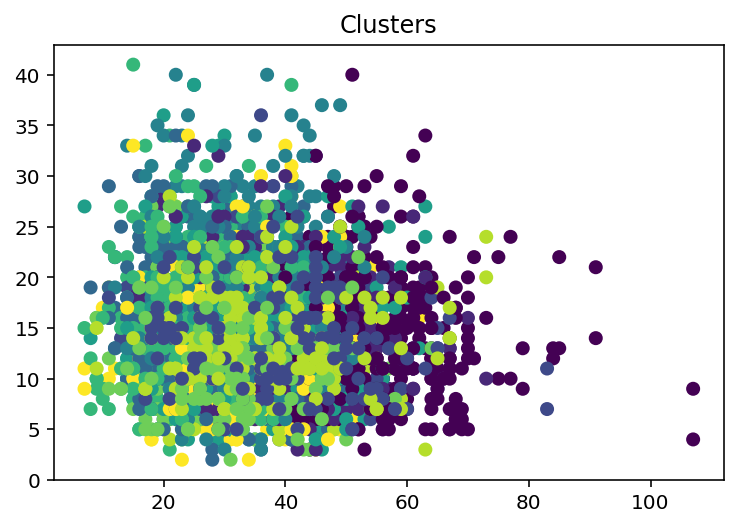

In [137]:
print(np.unique(y_pred))
plt.scatter(clust_data.ix[:, 0], clust_data.ix[:, 9], c=y_pred)
plt.title("Clusters")

plt.show()

In [147]:
clust_stats = clust_data.describe(percentiles=[0.1, 0.35, 0.65, 0.9])
clust_stats

,AerialsTotalFT,CornersTotalFT,DispossessedFT,DribbleSuccessFT,DribbledPastFT,DribblesAttemptedFT,DribblesWonFT,Formation,FoulsCommitedFT,InterceptionsFT,OffsidesCaughtFT,PassSuccessFT,PassesKeyFT,PossessionFT,RatingsFT,ShotsBlockedFT,ShotsOnTargetFT,ShotsTotalFT,TackleSuccessFT,TacklesTotalFT,Team
count,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000
mean,35.017105,5.397368,11.588947,54.083679,8.950789,16.239211,8.950789,1.726842,11.129737,14.997105,2.115526,67.506779,9.908684,40.099997,6.455945,3.564211,4.392105,13.206053,70.060913,27.810526,12.090000
std,12.296010,2.956737,4.387458,16.412515,4.353727,6.558574,4.353243,0.946928,3.459427,5.820220,1.602535,8.501967,4.533555,21.174401,0.206505,2.378190,2.463514,5.489986,11.061015,8.012158,7.648352
min,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,40.610000,0.000000,0.200000,5.670000,0.000000,0.000000,1.000000,27.780000,7.000000,1.000000
10%,20.000000,2.000000,6.000000,33.330000,4.000000,8.000000,4.000000,0.000000,7.000000,8.000000,0.000000,56.240000,5.000000,0.500000,6.200000,1.000000,2.000000,7.000000,55.668000,18.000000,2.900000
35%,30.000000,4.000000,10.000000,48.676500,7.000000,13.000000,7.000000,2.000000,10.000000,12.000000,1.000000,64.270000,8.000000,42.246500,6.380000,2.000000,3.000000,11.000000,65.910000,24.000000,8.000000
50%,34.000000,5.000000,11.000000,54.170000,8.000000,16.000000,8.000000,2.000000,11.000000,14.000000,2.000000,67.640000,9.000000,47.410000,6.450000,3.000000,4.000000,12.000000,70.450000,27.000000,11.000000
65%,38.000000,6.000000,13.000000,60.000000,10.000000,18.000000,10.000000,2.000000,12.000000,17.000000,2.000000,71.207000,11.000000,51.353500,6.520000,4.000000,5.000000,15.000000,74.640000,30.000000,14.350000
90%,51.000000,9.000000,18.000000,75.000000,15.000000,25.000000,15.000000,3.000000,16.000000,23.000000,4.000000,78.650000,16.000000,60.220000,6.730000,7.000000,8.000000,21.000000,84.215000,38.000000,23.100000
max,107.000000,19.000000,35.000000,100.000000,33.000000,49.000000,33.000000,4.000000,25.000000,41.000000,11.000000,91.520000,36.000000,74.710000,7.410000,19.000000,17.000000,43.000000,100.000000,62.000000,28.000000


In [149]:
clust_kmeans_exp = clust_kmeans.copy()
for col in clust_kmeans.columns:
    for i, row in enumerate(clust_kmeans[col]):
        print(i, row)
        if clust_kmeans.ix[i,col] < clust_stats.ix['10%', col]:
            clust_kmeans_exp.ix[i,col] = 'V. Low'
        elif clust_kmeans.ix[i,col] < clust_stats.ix['35%', col]:
            clust_kmeans_exp.ix[i,col] = 'Low'
        elif clust_kmeans.ix[i,col] > clust_stats.ix['90%', col]:
            clust_kmeans_exp.ix[i,col] = 'V. High'
        elif clust_kmeans.ix[i,col] > clust_stats.ix['65%', col]:
            clust_kmeans_exp.ix[i,col] = 'High'
        else:
            clust_kmeans_exp.ix[i,col] = 'Medium'
clust_kmeans_exp = clust_kmeans_exp.T

0 54.05620608899305
1 38.61861861861863
2 38.45454545454547
3 28.643584521384874
4 32.35412474849096
5 34.43561643835616
6 26.690573770491717
7 32.48872180451129
8 36.439834024896264
9 32.41913439635537
0 5.6252927400468415
1 4.4024024024024015
2 4.660079051383399
3 5.981670061099786
4 3.748490945674036
5 4.9753424657534255
6 5.692622950819679
7 6.545112781954887
8 4.510373443983405
9 7.3826879271070505
0 11.334894613583135
1 10.741741741741738
2 10.316205533596836
3 11.23217922606924
4 10.855130784708251
5 13.005479452054804
6 12.639344262295086
7 11.672932330827068
8 11.26141078838174
9 12.2255125284738
0 52.374473067915694
1 26.97894894894885
2 44.20885375494071
3 39.20219959266797
4 54.767122736418514
5 78.58936986301364
6 55.60973360655738
7 63.93552631578948
8 72.9884232365145
9 59.44870159453303
0 7.857142857142858
1 9.03903903903904
2 10.893280632411066
3 6.118126272912463
4 10.442655935613692
5 9.0
6 12.905737704918074
7 7.2481203007518795
8 11.609958506224082
9 5.441913439635

/Users/CEO/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """
/Users/CEO/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # Remove the CWD from sys.path while we load stuff.


In [154]:
tactics = {0:'keep possession around middle', 1 :'defensive + long balls',
2 :'', 3 :'', 4 :'', 5: '', 6 :'ultradefensive + don\'t retain possesion + long balls', 
7 :'short passing + possession in opposition half', 8 :'', 9: ''}
clust_kmeans_exp.ix['Tactic', :] = tactics

/Users/CEO/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


In [155]:
clust_kmeans_exp

,0,1,2,3,4,5,6,7,8,9
AerialsTotalFT,V. High,High,High,Low,Medium,Medium,Low,Medium,Medium,Medium
CornersTotalFT,Medium,Medium,Medium,Medium,Low,Medium,Medium,High,Medium,High
DispossessedFT,Medium,Medium,Medium,Medium,Medium,High,Medium,Medium,Medium,Medium
DribbleSuccessFT,Medium,V. Low,Low,Low,Medium,V. High,Medium,High,High,Medium
DribbledPastFT,Medium,Medium,High,Low,High,Medium,High,Medium,High,Low
DribblesAttemptedFT,Medium,Medium,Medium,Medium,Medium,Medium,High,High,Medium,High
DribblesWonFT,Medium,Low,Low,Low,Medium,High,High,High,High,High
Formation,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low
FoulsCommitedFT,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium
InterceptionsFT,Medium,Medium,Medium,Medium,High,Medium,Medium,Medium,Medium,Medium


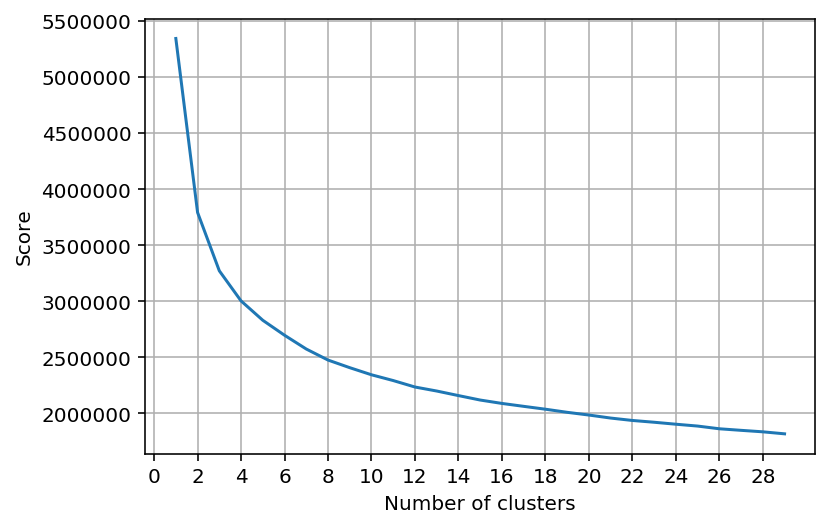

In [156]:
n_clust = range(1,30)
kmeans_ = [KMeans(n_clusters=i) for i in n_clust]
score = [-1*(kmeans_[i].fit(clust_data).score(clust_data)) for i in range(len(kmeans_))]
plt.grid(b=True, which='major', linestyle='-')
plt.plot(n_clust, score)
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.xticks(np.arange(0, max(n_clust)+1, 2.0))
plt.show()

In [145]:
n_clusters = 5
kmeansNorm = KMeans(n_clusters)
kmeansNorm.fit(norm_clust_data)
y_predNorm = kmeans.predict(norm_clust_data)
norm_clust_kmeans = pd.DataFrame(kmeansNorm.cluster_centers_, columns=norm_clust_data.columns)

In [146]:
norm_clust_kmeans.T

,0,1,2,3,4
AerialsTotalFT,0.316078,0.265984,0.318082,0.254842,0.267773
CornersTotalFT,0.245855,0.228905,0.250360,0.413050,0.292911
DispossessedFT,0.300429,0.327751,0.273872,0.312900,0.311248
DribbleSuccessFT,0.520906,0.509459,0.586365,0.553770,0.612380
DribbledPastFT,0.278333,0.286632,0.324616,0.216693,0.282461
DribblesAttemptedFT,0.302477,0.315454,0.298504,0.390214,0.345322
DribblesWonFT,0.236530,0.244208,0.266086,0.324863,0.318344
Formation,0.497357,0.434073,0.436644,0.439766,0.274625
FoulsCommitedFT,0.436487,0.441196,0.447917,0.369103,0.422912
InterceptionsFT,0.373394,0.352171,0.304268,0.297436,0.285455


[2]


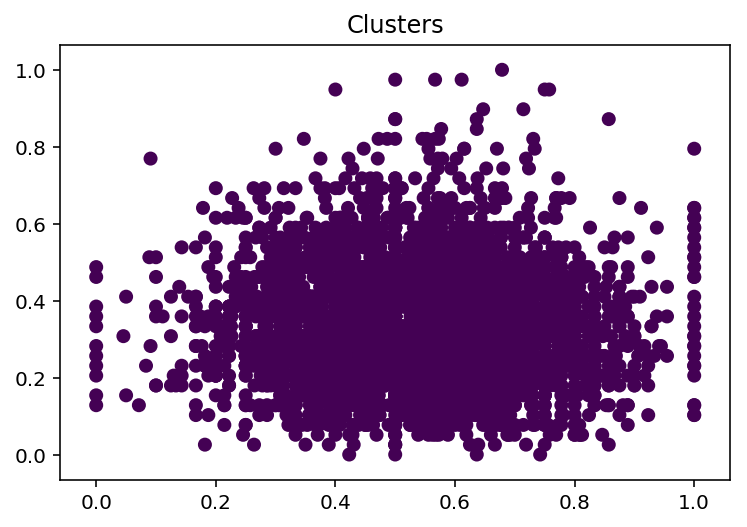

In [144]:
print(np.unique(y_predNorm))
plt.scatter(norm_clust_data.ix[:, 3], norm_clust_data.ix[:, 9], c=y_predNorm)
plt.title("Clusters")

plt.show()

In [141]:
y_predNorm

array([2, 2, 2, ..., 2, 2, 2], dtype=int32)